# Part_3: Stroke_Prediction - Czy palenie przyczynia się do udaru mózgu?  <span style="color:blue">Analiza ONE-WAY ANOVA</span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df= pd.read_csv('c:/1/Stroke_Prediction_NUM.csv')
df.head(3)

,Unnamed: 0,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
0,0,30650,Male,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,58.093151,"(53.126, 59.076]",1,1,2,1,1,5
1,1,57008,Female,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,70.076712,"(65.121, 74.11]",0,1,2,0,0,7
2,2,53725,Female,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0,52.041096,"(48.082, 53.126]",0,1,2,1,0,4


Celem naszego badania jest sprawdzenie, czy istnieje istotny statystycznie wpływ palenia na udar mózgu.

Podzielę pacjentów na trzy grupy: 

1. ci co kiedyś palili,
2. ci co palą,
3. ci, którzy nigdy nie palili.



<div class="alert-info">
 
 - h0: poziom zapadalności na udar (średnia) jest taki sam pomiędzy grupami
 - h1: poziom zapadalności na udar  (średnia) jest statycznie inny pomiędzy strefami
</div>

In [2]:
pd.pivot_table(df, index= ['Smoking_Status'], columns = "Stroke", values= "ID", aggfunc= ['count'])

count     
Stroke               0    1
Smoking_Status             
formerly smoked   6912  180
never smoked     15489  256
smokes            6113  112

### <span style="color:blue">Test ANOVA</span>

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_H = ols('Stroke ~ C(Smoking_Status)', data=df).fit()

anova_table = sm.stats.anova_lm(model_H, typ=2)
print(anova_table)

                       sum_sq       df         F    PR(>F)
C(Smoking_Status)    0.412747      2.0  11.16233  0.000014
Residual           537.254034  29059.0       NaN       NaN


<div class="alert-info">
<span style="color:darkblue">
Interpretacja: Wartość P uzyskana z analizy ANOVA jest znacząca (P<'0,05'), a zatem wnioskujemy, że istnieje istotna statystycznie różnica w zapadalności na udar mózgu między grupami osób palących i niepalących. Innymi słowy, istnieje statystycznie istotny wpływ palenia na udary mózgu.
                                                                     
</span>
</div>

ANOVA pokazała, że istnieją statystycznie istotne różnice. Niestety ANOVA nie wskazuje, które grupy różnią się od siebie. 
Aby poznać pary różniące się istotnie, należy przeprowadzić analizę wielokrotnego porównania par (porównanie post-hoc) za pomocą testu HSD Tukeya.

### <span style="color:blue">Testu HSD Tukeya</span>

In [4]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df['Stroke'], groups=df['Smoking_Status'], alpha=0.05)
print(m_comp)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
     group1        group2    meandiff  lower   upper  reject
------------------------------------------------------------
formerly smoked never smoked -0.0091  -0.0137 -0.0046  True 
formerly smoked    smokes    -0.0074  -0.0129 -0.0019  True 
  never smoked     smokes     0.0017   -0.003  0.0065 False 
------------------------------------------------------------


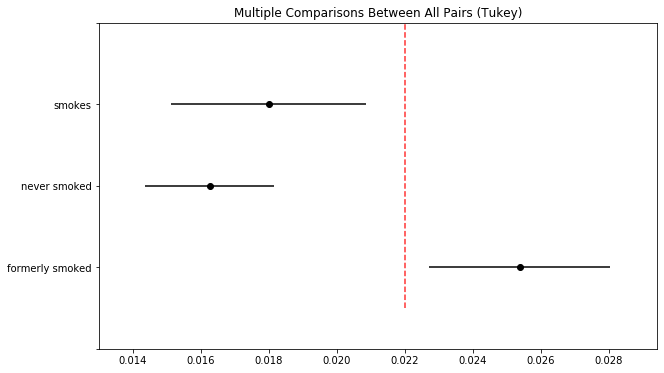

In [5]:
m_comp.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=0.022,ymin=-0.5,ymax=3.5, color="red", alpha=0.8, linestyle='--')

<div class="alert-info">
<span style="color:darkblue">

Test Tukey HSD wykazał statystycznie istotną różnicę w zapadalności na udary w następujących parach:

- "formerly smoked" i "never smoked" 
- "formerly smoked" i "smokes" 

Powyższe wyniki z Tukey HSD sugerują, że oprócz wymienionych zestawów, wszystkie inne porównania par zachowują hipotezę zerową, czyli w pozostałych parach nie istnieją istotne różnice statystyczne w poziomie zapadalności na udar. Okazuje się, że decydujące jest to, że ktoś kiedyś palił i potem rzucił.

</span>
</div>

### Sprawdzenie spełnienia warunków ANOVA
Warunki: 
1. wartości rezydualne mają rozkład normalny (test Shapiro Wilksa)
2. wariancje w grupach są jednorodne (test Levene lub Bartlett)
3. obserwacje są prowadzone niezależnie od siebie 

### <span style="color:blue">Test Levene'a</span> Sprawdzenie jednorodności wariancji

<div class="alert-info">
<span style="color:darkblue">
    
    
Hipoteza zerowa : grupy z populacji mają równe wariancje.

In [6]:
PKS = pd.pivot_table(df, index = 'Gender', columns = 'Smoking_Status', values='Stroke')
PKS.head(4)

Smoking_Status,formerly smoked,never smoked,smokes
Gender,,,
Female,0.020127,0.017203,0.015629
Male,0.031891,0.014419,0.021064


<div class="alert-danger">
Test Levene'a nie toleruje pustych wartości NaN
    
</div>

In [7]:
P01=PKS['formerly smoked'].dropna(how='any')
P02=PKS['never smoked'].dropna(how='any')
P03=PKS['smokes'].dropna(how='any')

Wykresy przedstawiają statystyki poziomu prawdopodobieństwa w czterech grupach.

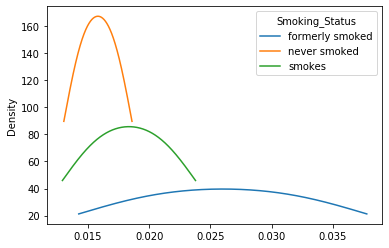

In [8]:
PKS.plot.kde()

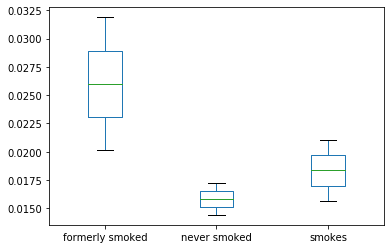

In [9]:
import matplotlib.pyplot as plt
PKS.boxplot(column=['formerly smoked', 'never smoked', 'smokes'], grid=False)

Wartość wynikowa 'Stroke' jest wartością dyskretną. Nie ma więc potrzeby sprawdzania zgodności rozkładu normalnego. 
Gdybyśmy jednak chcieli to sprawdzić testem test Levenea ...

In [10]:
import scipy.stats as stats
w,p = stats.levene(P01,P02,P03)
print("Value:   ",w)
print("p-value: ",p)

Value:    2.652849026336751e+30
p-value:  4.2517535804756894e-46


<div class="alert-info">
<span style="color:darkblue">
    
Ponieważ wartość P jest znacząca, bo jest mniejsza od współczynnika ufności 0.05 (p<0.05), należy odrzucić hipotezę zerową - wartości rezydualne nie mają rozkładu normalnego.
</span>
</div>

Przyjrzymy się bliżej resztom modelu. Jak można się było spodziewać to wartości dyskretne...

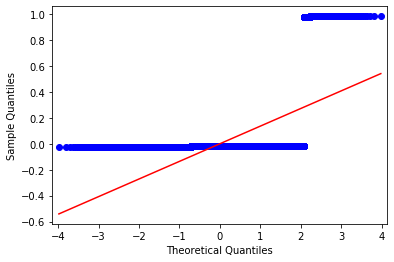

In [11]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

qqplot(model_H.resid, line='s')
pyplot.show()